# Control for Profile Size

This notebook looks at evaluation metrics controlled for profile size.

The `OutputAnalysis` and `LastFMOutput` notebooks must be run first.

## Setup

In [1]:
library(dplyr)
library(readr)
library(ggplot2)
library(tidyr)
library(modelr)
library(tibble)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
options(repr.plot.height=4.5, repr.matrix.max.rows=10)

In [3]:
source("plot-tools.R")

## Read Data

In [4]:
results = read_csv("build/integrated-user-results.csv") %>%
    filter(DataSet != "LFM360K")
results

ERROR: Error: 'build/integrated-user-results.csv' does not exist in current working directory ('/home/mtian/IdeaProjects/piret-eval-demographics').


## Explore Variables

There are two ways we can try to model: we can consider all algorithms, and just try to predict based on e.g. nratings. The other is that we can aggregate by user to produce a per-user 'difficulty' score. We will do the latter to avoid statistical non-independence problems.

In [6]:
user.metrics = results %>%
    group_by(DataSet, user, gender, age, nitems) %>%
    summarize(nDCG=mean(nDCG), AvgRR=mean(RecipRank))
user.metrics

DataSet,user,gender,age,nitems,nDCG,AvgRR
LFM1K,1,M,NA,658,0.04262668,0.001081754
LFM1K,2,F,NA,1287,0.36057933,0.277196886
LFM1K,3,M,18-24,940,0.11123080,0.004392435
LFM1K,4,F,NA,1774,0.12700606,0.033700584
LFM1K,5,M,NA,1081,0.10126860,0.007196409
⋮,⋮,⋮,⋮,⋮,⋮,⋮
ML1M,6036,F,25-34,883,0.1915258,0.05052384
ML1M,6037,F,45-49,197,0.1640507,0.01605005
ML1M,6038,F,56+,15,0.1626213,0.02621624
ML1M,6039,F,45-49,118,0.1757297,0.02152721


Let's plot to see what this is looking like:

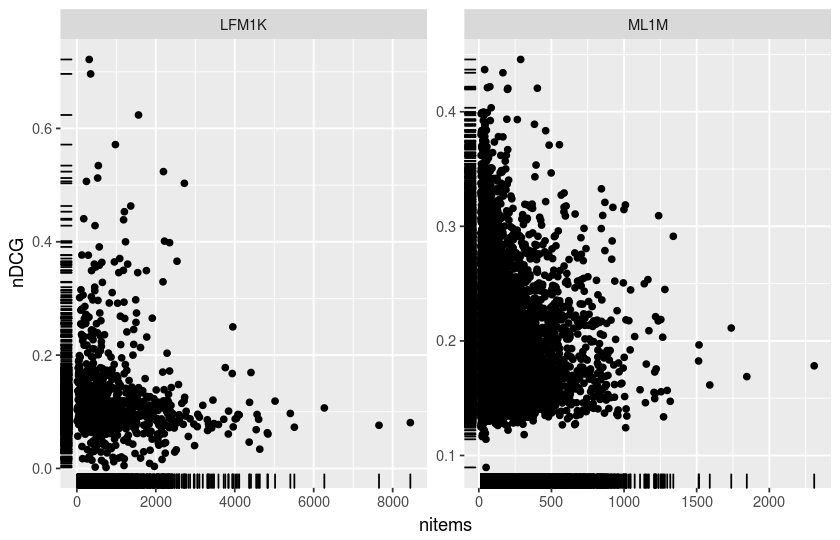

In [7]:
ggplot(user.metrics) +
    aes(x=nitems, y=nDCG) +
    geom_point() + 
    geom_rug() +
    facet_wrap(~ DataSet, scales="free")

Oof, that distribution is concentrated. Let's log the number of ratings, since log is often a good transform for counts:

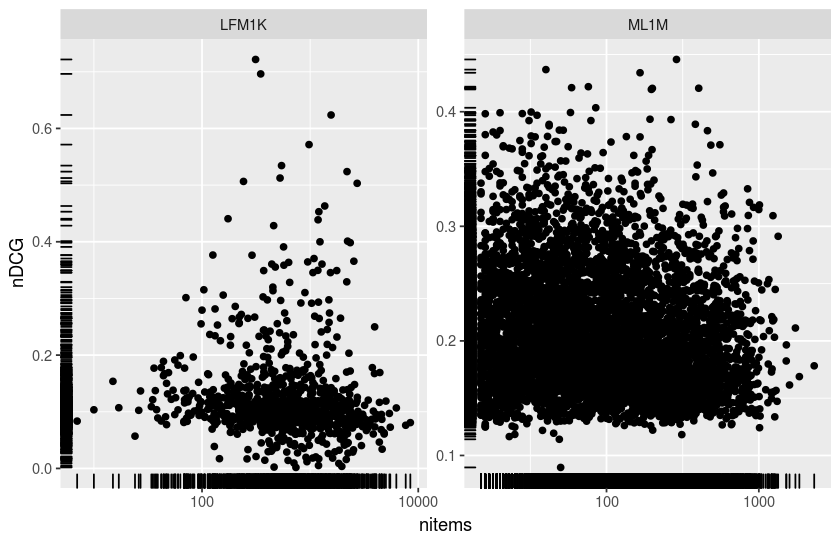

In [8]:
ggplot(user.metrics) +
    aes(x=nitems, y=nDCG) +
    geom_point() + 
    geom_rug() +
    scale_x_log10() +
    facet_wrap(~ DataSet, scales="free")

Looking better. Let's see how the difficulty (nDCG) is distributed (Q-Q plot):

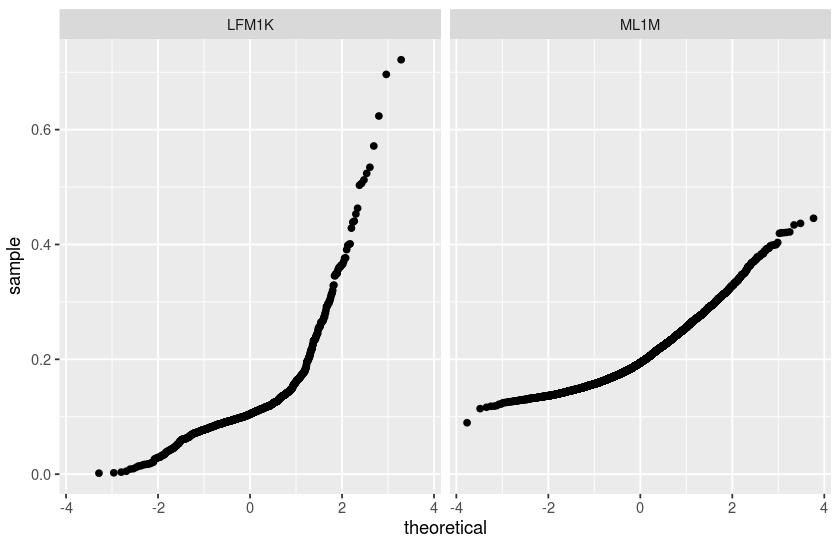

In [9]:
ggplot(user.metrics) +
    aes(sample=nDCG) +
    geom_qq() +
    facet_wrap(~ DataSet)

That isn't quite normal; however, a log transform looks like it will be too aggressive. Let's try a square root:

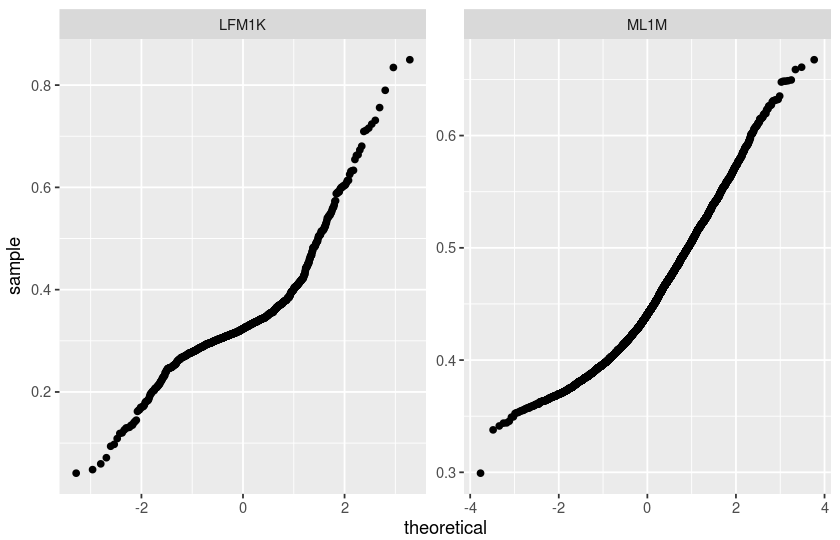

In [14]:
ggplot(user.metrics) +
    aes(sample=sqrt(nDCG)) +
    geom_qq() +
    facet_wrap(~ DataSet, scales="free")

Better. LFM1K isn't as good.

## Linear Modeling

We are going to build a linear model for each data set separately.

In [19]:
ml.ndcg.mod = lm(sqrt(nDCG) ~ log10(nitems), data=filter(user.metrics, DataSet == "ML1M"))
summary(ml.ndcg.mod)


Call:
lm(formula = sqrt(nDCG) ~ log10(nitems), data = filter(user.metrics, 
    DataSet == "ML1M"))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.155206 -0.039939 -0.008945  0.033625  0.226957 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.485360   0.002997  161.95   <2e-16 ***
log10(nitems) -0.018200   0.001486  -12.25   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.05298 on 6038 degrees of freedom
Multiple R-squared:  0.02426,	Adjusted R-squared:  0.02409 
F-statistic: 150.1 on 1 and 6038 DF,  p-value: < 2.2e-16


In [18]:
lfm.ndcg.mod = lm(sqrt(nDCG) ~ log10(nitems), data=filter(user.metrics, DataSet == "LFM1K"))
summary(lfm.ndcg.mod)


Call:
lm(formula = sqrt(nDCG) ~ log10(nitems), data = filter(user.metrics, 
    DataSet == "LFM1K"))

Residuals:
     Min       1Q   Median       3Q      Max 
-0.29607 -0.04599 -0.01589  0.02556  0.50337 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.405927   0.018485  21.960  < 2e-16 ***
log10(nitems) -0.023933   0.006614  -3.618 0.000312 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.09426 on 979 degrees of freedom
Multiple R-squared:  0.0132,	Adjusted R-squared:  0.01219 
F-statistic: 13.09 on 1 and 979 DF,  p-value: 0.0003116


Let's fill our data with these models.

We compute residuals manually, because we linear model residuals are in square-root space. For checking the model, we want:

$$\epsilon_i = \sqrt{\mathrm{nDCG}}-y_i$$

However, we also do want the _error_, which is

$$e_i = \mathrm{nDCG} - y_i^2$$

In [21]:
lfm.ndcg.preds = user.metrics %>%
    select(-AvgRR) %>%
    filter(DataSet == "LFM1K") %>%
    add_predictions(lfm.ndcg.mod)
ml.ndcg.preds = user.metrics %>%
    select(-AvgRR) %>%
    filter(DataSet == "ML1M") %>%
    add_predictions(ml.ndcg.mod)
ndcg.preds = bind_rows(lfm.ndcg.preds, ml.ndcg.preds) %>%
    rename(predRoot=pred) %>%
    mutate(pred = predRoot * predRoot, resid=sqrt(nDCG) - predRoot, error=nDCG-pred)
ndcg.preds

DataSet,user,gender,age,nitems,nDCG,predRoot,pred,resid,error
LFM1K,1,M,NA,658,0.04262668,0.3384783,0.1145676,-0.132016047,-0.0719409078
LFM1K,2,F,NA,1287,0.36057933,0.3315054,0.1098958,0.268977219,0.2506835233
LFM1K,3,M,18-24,940,0.11123080,0.3347711,0.1120717,-0.001258229,-0.0008408545
LFM1K,4,F,NA,1774,0.12700606,0.3281697,0.1076953,0.028209421,0.0193107246
LFM1K,5,M,NA,1081,0.10126860,0.3333184,0.1111011,-0.015091078,-0.0098325263
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
ML1M,6036,F,25-34,883,0.1915258,0.4317422,0.1864014,0.005894379,0.005124449
ML1M,6037,F,45-49,197,0.1640507,0.4435997,0.1967807,-0.038567936,-0.032729965
ML1M,6038,F,56+,15,0.1626213,0.4639546,0.2152539,-0.060691344,-0.052632620
ML1M,6039,F,45-49,118,0.1757297,0.4476508,0.2003913,-0.028449631,-0.024661621


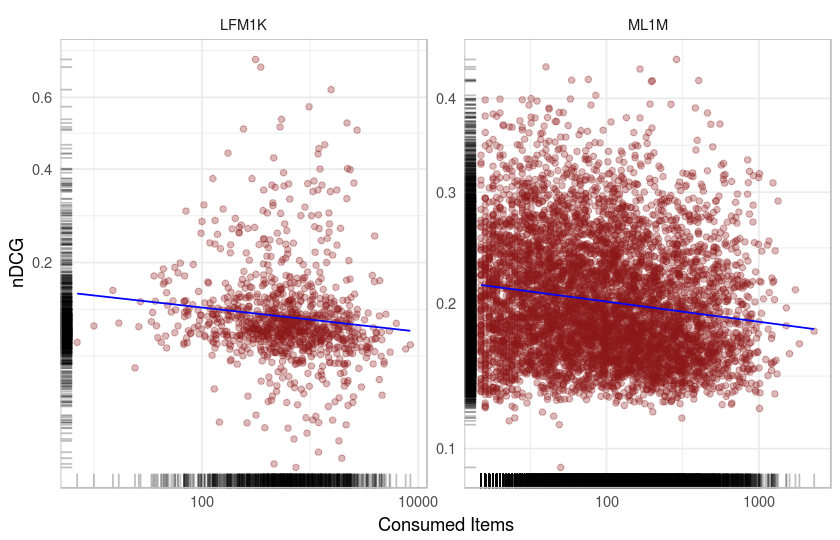

In [70]:
make.plot("linear-model-fit", width=5, height=2.5, {
    ggplot(ndcg.preds) +
        aes(x=nitems, y=nDCG) +
        geom_point(color="firebrick4", alpha=0.3) + 
        geom_line(mapping=aes(y=pred), color="blue") +
        geom_rug(alpha=0.25) +
        scale_x_log10() + scale_y_sqrt() +
        facet_wrap(~ DataSet, scales="free") +
        theme_paper() +
        xlab("Consumed Items")
})

Curiously, both of these have _negative_ slope.

## Controlled Gender Results

Now we want to control for the size of user's profile. Since male users rate more movies than female users, and long profiles are easier to predict for, it is possible that the increase in improvement for male users is due to rating size.

We will control for that by using our linear model for predicting 'difficulty' using profile size, and look at the remaining effect of gender on accuracy.

In [24]:
gender.corr.ndcg = results %>%
    select(DataSet, user, Algorithm, gender, nDCG) %>%
    inner_join(select(ndcg.preds, DataSet, user, Pred.nDCG=pred)) %>%
    mutate(Corr.nDCG = nDCG - Pred.nDCG) %>%
    group_by(DataSet, gender, Algorithm) %>%
    summarize(nDCG=mean(nDCG), Corr.nDCG=mean(Corr.nDCG))
gender.corr.ndcg

Adding missing grouping variables: `gender`, `age`
Joining, by = c("DataSet", "user", "gender")


DataSet,gender,Algorithm,nDCG,Corr.nDCG
LFM1K,F,II-B,0.18379674,0.06727621
LFM1K,F,II-C,0.08752032,-0.02900021
LFM1K,F,II-CS,0.17642666,0.05990613
LFM1K,F,MF-B,0.07203324,-0.04448729
LFM1K,F,MF-C,0.16429308,0.04777255
⋮,⋮,⋮,⋮,⋮
ML1M,M,MF-B,0.1706398,-0.03119155
ML1M,M,MF-E,0.1526360,-0.04919539
ML1M,M,Pop-B,0.2364052,0.03457383
ML1M,M,UU-B,0.3519757,0.15014436


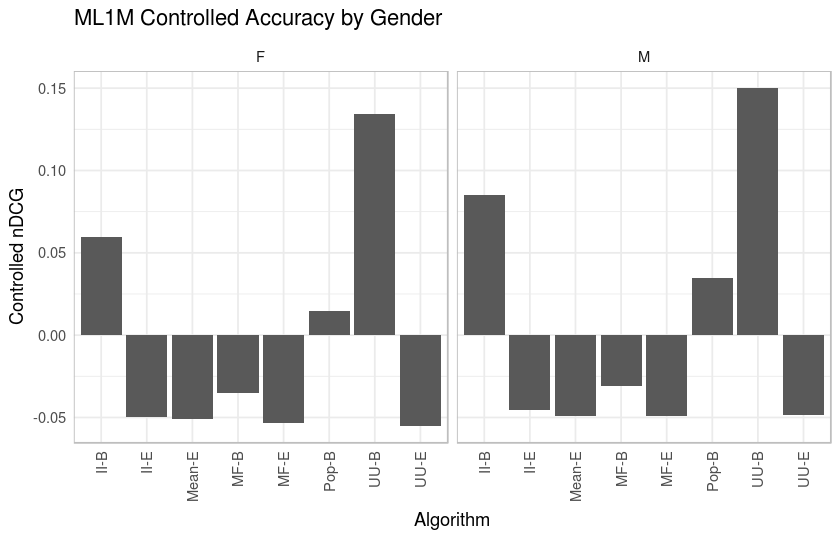

In [33]:
make.plot("controlled-gender-ndcg-ml", width=5, height=2, {
    ggplot(gender.corr.ndcg %>% filter(DataSet == "ML1M")) +
        aes(x=Algorithm, y=Corr.nDCG) +
        geom_bar(stat="identity", position="dodge") +
        facet_grid(~ gender, scales="free") +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
        ylab("Controlled nDCG") +
        ggtitle("ML1M Controlled Accuracy by Gender")
})

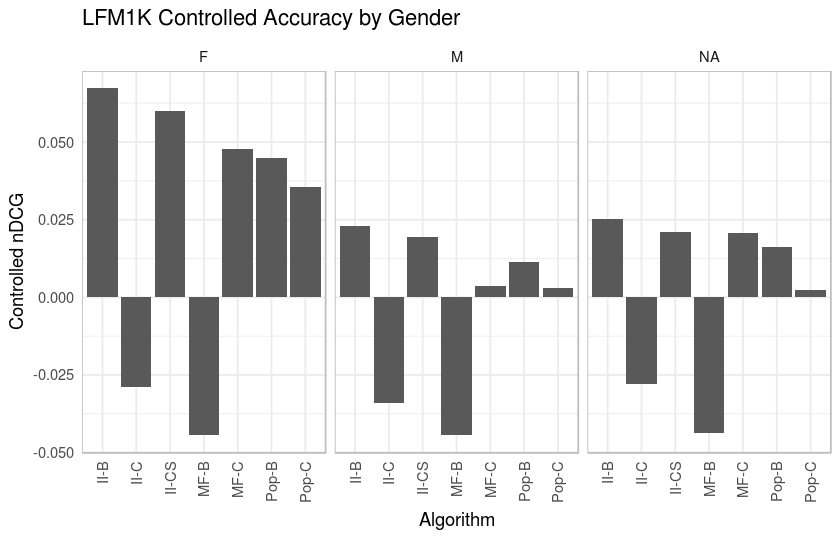

In [32]:
make.plot("controlled-gender-ndcg-lfm", width=5, height=2, {
    ggplot(gender.corr.ndcg %>% filter(DataSet == "LFM1K")) +
        aes(x=Algorithm, y=Corr.nDCG) +
        geom_bar(stat="identity", position="dodge") +
        facet_grid(~ gender, scales="free") +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
        ylab("Controlled nDCG")  +
        ggtitle("LFM1K Controlled Accuracy by Gender")
})

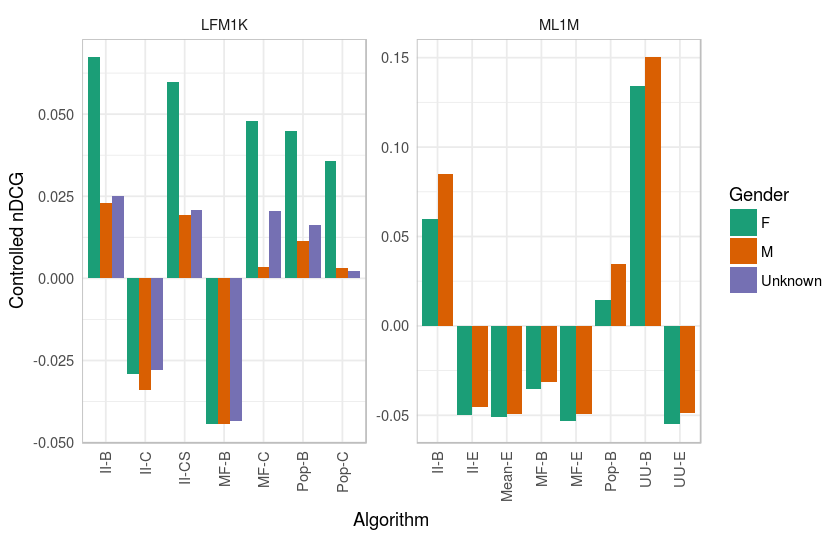

In [39]:
make.plot("controlled-gender-ndcg", width=5, height=2.5, {
    ggplot(gender.corr.ndcg %>% ungroup() %>% mutate(Gender=coalesce(gender, "Unknown"))) +
        aes(x=Algorithm, y=Corr.nDCG, fill=Gender) +
        geom_bar(stat="identity", position="dodge") +
        facet_wrap(~ DataSet, scales="free") +
        scale_fill_brewer(palette="Dark2") +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
        ylab("Controlled nDCG")
})

## Controlled Age Results

In [29]:
age.corr.ndcg = results %>%
    filter(DataSet == "ML1M") %>%
    select(user, Algorithm, age, nDCG) %>%
    inner_join(select(ndcg.preds, user, Pred.nDCG=pred)) %>%
    mutate(Corr.nDCG = nDCG - Pred.nDCG) %>%
    group_by(age, Algorithm) %>%
    summarize(nDCG=mean(nDCG), Corr.nDCG=mean(Corr.nDCG))
head(age.corr.ndcg)

Adding missing grouping variables: `DataSet`, `gender`, `age`
Joining, by = c("user", "age")


age,Algorithm,nDCG,Corr.nDCG
1-17,II-B,0.2620533,0.058460123
1-17,II-E,0.1457117,-0.057881523
1-17,Mean-E,0.1419764,-0.061616740
1-17,MF-B,0.1634625,-0.040130645
1-17,MF-E,0.1454232,-0.058169966
1-17,Pop-B,0.2061791,0.002585935


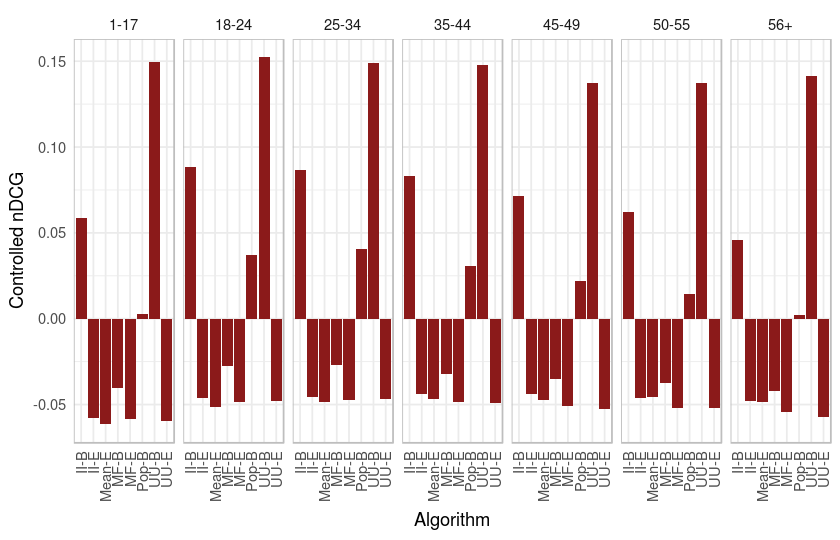

In [41]:
make.plot("controlled-age-ndcg-ml", width=5, height=2, {
    ggplot(age.corr.ndcg) +
        aes(x=Algorithm, y=Corr.nDCG) +
        geom_bar(stat="identity", position="dodge", fill="firebrick4") +
        facet_grid(~ age, scales="free") +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
        ylab("Controlled nDCG")
})

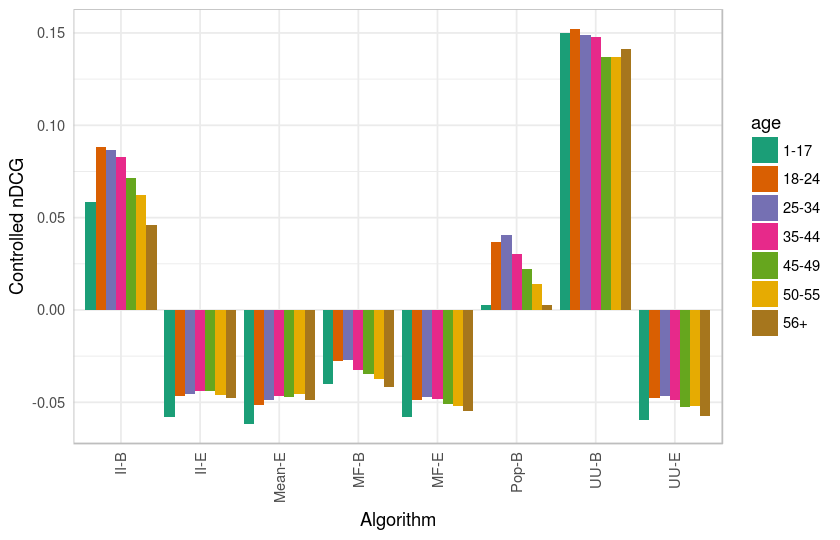

In [61]:
make.plot("controlled-age-ndcg", width=5, height=2, {
    ggplot(age.corr.ndcg) +
        aes(x=Algorithm, y=Corr.nDCG, fill=age) +
        geom_bar(stat="identity", position="dodge") +
        scale_fill_brewer(palette="Dark2") +
        theme_paper() +
        theme(axis.text.x = element_text(angle = 90, hjust = 1, vjust=0.5)) +
        ylab("Controlled nDCG")
})

Discrepancy in performance is robust to controls for size.